## Model the Target as Binary Variable - Classification Problem

#### Load Libraries

In [55]:
import pandas as pd
pd.options.display.max_columns = 200
pd.options.display.max_rows = 1000
from sklearn import preprocessing
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from tpot import TPOTClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import roc_auc_score
from scipy import interp
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score
from matplotlib import pyplot
from pandas import read_csv
from pandas import set_option
from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import print_function
import os
import subprocess
from sklearn.tree import DecisionTreeClassifier, export_graphviz
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#### Load the surrounding and sales data and join them to create a data set for learning

In [56]:
surrounding_pdf = pd.read_csv('../UseCase_3_Datasets/store_surrounding_pdf_exp.csv')
surrounding_nf_pdf = pd.read_csv('../UseCase_3_Datasets/new_features.csv')

surrounding_pdf = pd.merge(surrounding_nf_pdf,surrounding_pdf,on='store_code',how='inner')
surrounding_pdf = surrounding_pdf.drop_duplicates()

y_column = 'total_sales'

# store_sales = pd.read_csv('../UseCase_3_Datasets/sales_daily_simple_sum.csv')
# sales_pdf_daily_sub = store_sales[['store_code','total_sales']]

#store_sales = pd.read_csv('../UseCase_3_Datasets/sales_per_hr.csv')
#sales_pdf_daily_sub = store_sales[['store_code','sales_per_hr']]

store_sales = pd.read_csv('../UseCase_3_Datasets/sales_per_day_period.csv')
sales_pdf_daily_sub = store_sales[['store_code','total_sales','Morning','Afternoon','Evening','sales_pattern']]
# sales_pdf_daily_sub = sales_pdf_daily_sub[(sales_pdf_daily_sub['sales_pattern'] == 'Evening') |
#                                           (sales_pdf_daily_sub['sales_pattern'] == 'Afternoon')]
sales_pdf_daily_sub = sales_pdf_daily_sub[['store_code',y_column]]


In [57]:
# # #Read other population realted information from wiki
# pop_features_pdf = pd.read_csv('../UseCase_3_Datasets/swiss_pop_features_2.csv',sep=';',header=0)
# pop_features_pdf.head()
# pop_features_pdf.columns
# pop_pdf = pd.read_csv('../UseCase_3_Datasets/swiss_pop.csv',sep=',')
# pop_pdf.head()

# # #Comnine with surrounding data using city code informartion
# surrounding_pdf = pd.merge(pop_features_pdf,surrounding_pdf,on='city',how='inner')
# surrounding_pdf = surrounding_pdf.drop_duplicates()
# surrounding_pdf = pd.merge(pop_pdf,surrounding_pdf,on='city',how='inner')
# surrounding_pdf = surrounding_pdf.drop_duplicates()
# surrounding_pdf['pop_above_20'] = 100-surrounding_pdf['pop_under_20']
# surrounding_pdf= surrounding_pdf.drop('cant',axis=1)
# surrounding_pdf.head()

In [58]:
print("Surrounding Shape",surrounding_pdf.shape)
print("Sales Shape",sales_pdf_daily_sub.shape)

Surrounding Shape (525, 705)
Sales Shape (905, 2)


### Data Cleaning

#### Remove variable that have ony one unique value

In [59]:
#Join Store and Surroounding datasets
sales_surrounding_pdf = pd.merge(sales_pdf_daily_sub,surrounding_pdf,on='store_code',how='inner')
sales_surrounding_pdf = sales_surrounding_pdf.drop_duplicates()
# Dropping columns that do not provide useful information for this analysis
for i in sales_surrounding_pdf.columns:
    if sales_surrounding_pdf[i].nunique() == 1:
        sales_surrounding_pdf.drop(i, axis = 1, inplace = True)
print("Sales Surrounding Shape",sales_surrounding_pdf.shape)

Sales Surrounding Shape (524, 699)


In [60]:
# #Visualization of individual attributes
# #Histogram
# sales_surrounding_pdf.hist(sharex=False,sharey=False,xlabelsize=0.25,ylabelsize=0.25,figsize=(20,20))
# pyplot.show()

In [61]:
# sales_surrounding_pdf.plot(kind='density', subplots=True, layout=(10,18), sharex=False, legend=False,fontsize=1,
#                           figsize=(20,20))
# pyplot.show()

In [62]:
# fig = pyplot.figure(figsize=(15,15))
# ax = fig.add_subplot(111)
# cax = ax.matshow(sales_surrounding_pdf.corr(),vmin=-1, vmax=1)
# fig.colorbar(cax)
# pyplot.show()

#### One hot Encoding for categorical values

In [63]:
import math

sales_surrounding_pdf_ohe = pd.get_dummies(sales_surrounding_pdf)
#Create Train,Test without imputation
#X = sales_surrounding_pdf.loc[:, sales_surrounding_pdf.columns != 'total_sales']
#X = sales_surrounding_pdf.loc[:, sales_surrounding_pdf.columns != 'store_code']

y = sales_surrounding_pdf_ohe[y_column].apply(lambda x : math.log(x+1))

X = sales_surrounding_pdf_ohe.drop([y_column,'store_code'],axis=1)
#X = sales_surrounding_pdf.drop('store_code',axis=1)

# print("Shape ",X.shape)
# print ("Shape ",y.shape )

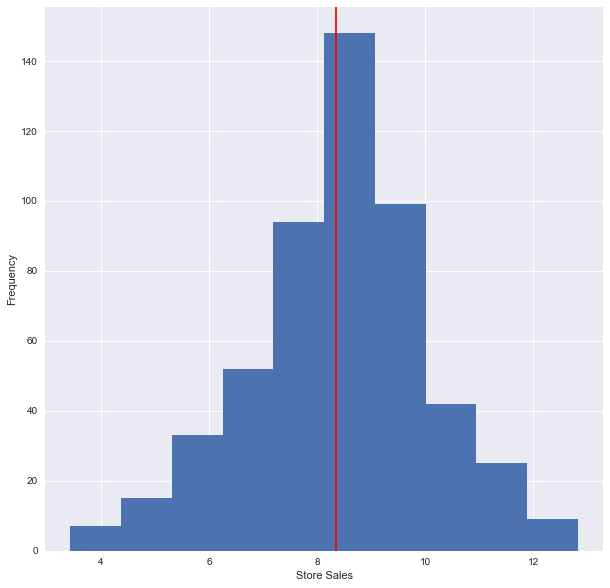

In [64]:
y.plot(kind='hist',subplots=True,fontsize=10,figsize=(10,10),grid=True,)
# y_test.hist(bins=20,figsize=(10,10))
pyplot.axvline(x=8.35,color='red')
pyplot.xlabel("Store Sales")
pyplot.show()

#### Creation of Test and Train set

In [65]:
#Divide into train and test
validation_size = 0.20
seed = 33
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=validation_size,random_state=seed)

#### Target Creation
Since we plan to make a binary target, we try to find a split point, looking at the data 
Also, the split point is created in such a way, that we do dont create a unbalanced dataset to learn and predict.

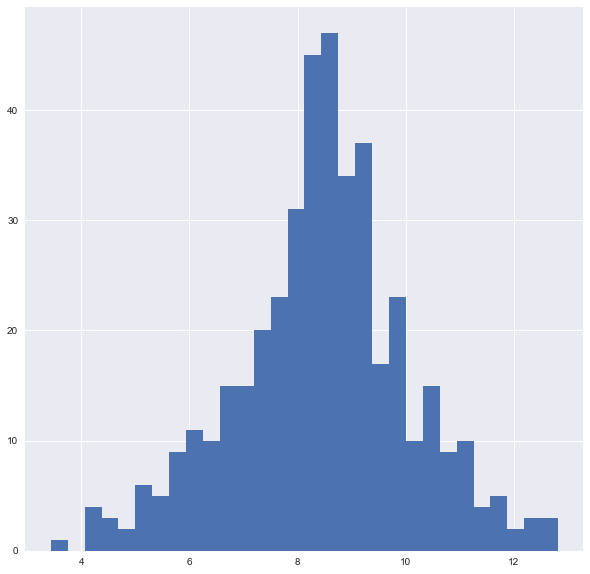

In [66]:
# xtick_list = range(0,500000,50000)
# ytick_list = range(0,y_train.shape[0],30)
# y_train.plot(kind='hist',subplots=True,fontsize=10,figsize=(10,10),xticks=xtick_list,yticks=ytick_list)
y_train.hist(bins=30,figsize=(10,10))
# pyplot.xlabel("Store Sales")
# pyplot.show()

In [67]:
# y_train[y_train.values < 8].hist(bins=30,figsize=(10,10),)
# pyplot.xlabel("Store Sales")
# pyplot.show()

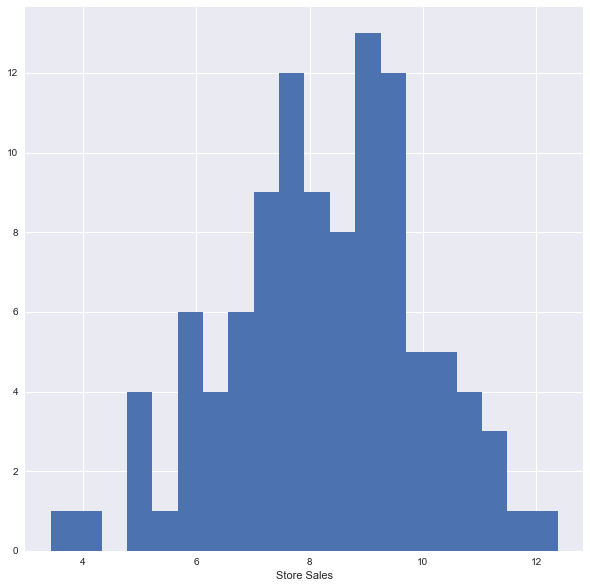

In [68]:
# xtick_list = range(0,500000,50000)
# ytick_list = range(0,y_test.shape[0],10)
#y_test.plot(kind='hist',subplots=True,fontsize=10,figsize=(10,10),grid=True,xticks=xtick_list,yticks=ytick_list)
y_test.hist(bins=20,figsize=(10,10))
pyplot.xlabel("Store Sales")
pyplot.show()

In [70]:
#Find the most balanced point of the data set :

for i in np.arange(7,10,0.15):
    y_train_sp = y_train.apply(lambda x : 1 if x >=i else 0 )
    y_test_sp = y_test.apply(lambda x : 1 if x >=i else 0)
    print ("Split Point ", i)
    print ("% of 0-class in Test ",y_test_sp.value_counts()[0]/ (y_test_sp.value_counts()[1]+y_test_sp.value_counts()[0])*100)
    print ("% of 0-class in Train ",y_train_sp.value_counts()[0]/ (y_train_sp.value_counts()[1]+y_train_sp.value_counts()[0])*100)
    print("\n")

Split Point  7.0
% of 0-class in Test  19.0476190476
% of 0-class in Train  17.661097852


Split Point  7.15
% of 0-class in Test  24.7619047619
% of 0-class in Train  19.3317422434


Split Point  7.3
% of 0-class in Test  25.7142857143
% of 0-class in Train  21.0023866348


Split Point  7.45
% of 0-class in Test  30.4761904762
% of 0-class in Train  23.6276849642


Split Point  7.6
% of 0-class in Test  34.2857142857
% of 0-class in Train  24.5823389021


Split Point  7.75
% of 0-class in Test  36.1904761905
% of 0-class in Train  27.923627685


Split Point  7.9
% of 0-class in Test  40.9523809524
% of 0-class in Train  31.0262529833


Split Point  8.05
% of 0-class in Test  43.8095238095
% of 0-class in Train  35.5608591885


Split Point  8.2
% of 0-class in Test  45.7142857143
% of 0-class in Train  38.4248210024


Split Point  8.35
% of 0-class in Test  49.5238095238
% of 0-class in Train  45.8233890215


Split Point  8.5
% of 0-class in Test  51.4285714286
% of 0-class in Train  4

In [16]:
#Based on the above histogram comparison threshold 50,000 is a good enough to make binary classification target
split_point = 8.35 
y_train = y_train.apply(lambda x : 1 if x >=split_point else 0 )
y_test = y_test.apply(lambda x : 1 if x >=split_point else 0)
y = y.apply(lambda x : 1 if x >=split_point else 0)

y_test.value_counts()
#Binary Targets created.

1    53
0    52
Name: total_sales, dtype: int64

In [17]:
y_test.value_counts()[0] / (y_test.value_counts()[1]+y_test.value_counts()[0])*100

49.523809523809526

In [18]:
y_train.value_counts()

1    227
0    192
Name: total_sales, dtype: int64

In [19]:
y_train.value_counts()[0] / (y_train.value_counts()[1]+y_train.value_counts()[0])*100

45.823389021479713

In [20]:
type(X_train)

pandas.core.frame.DataFrame

On the spot checks,try out some basic models and see, how they perform 

In [21]:
#Find Feature Importance via various methods
#1)Logistic Regression
#1.1) Logistic Regression with L1 Penalty (Lasso)
#2)Decision Tree

# Spot-Check Algorithms
models = []
num_folds = 10
seed = 42
scoring ='roc_auc'

models.append(('LR', LogisticRegression()))
models.append(('LR with L1 penalty', LogisticRegression(penalty='l1')))
models.append(('CART', DecisionTreeClassifier()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))


results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name,cv_results.mean(),cv_results.std())
    print(msg)

LR: 0.585009 (0.115225)
LR with L1 penalty: 0.595242 (0.119246)
CART: 0.569881 (0.091629)
LDA: 0.522499 (0.093368)
KNN: 0.554895 (0.061277)


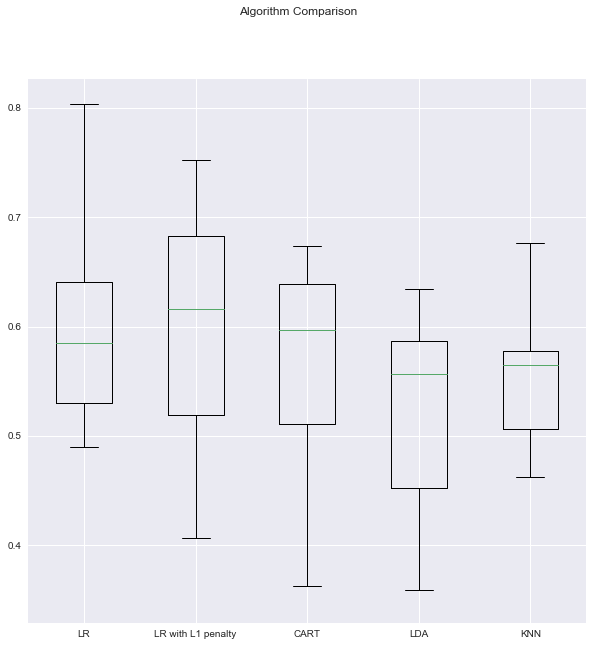

In [22]:
# Compare Algorithms
fig = pyplot.figure(figsize=(10,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [23]:
pipelines = []
pipelines.append(('Scaled LR', Pipeline([('Scaler', StandardScaler()),('LR',LogisticRegression())])))
pipelines.append(('Scaled LR with L1', Pipeline([('Scaler', StandardScaler()),('LR with L1',LogisticRegression(penalty='l1'))])))
pipelines.append(('Scaled CART', Pipeline([('Scaler', StandardScaler()),('CART',DecisionTreeClassifier(max_depth=5))])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN',KNeighborsClassifier())])))
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Scaled LR: 0.558057 (0.107658)
Scaled LR with L1: 0.579036 (0.122296)
Scaled CART: 0.584145 (0.096055)
ScaledKNN: 0.571015 (0.082552)


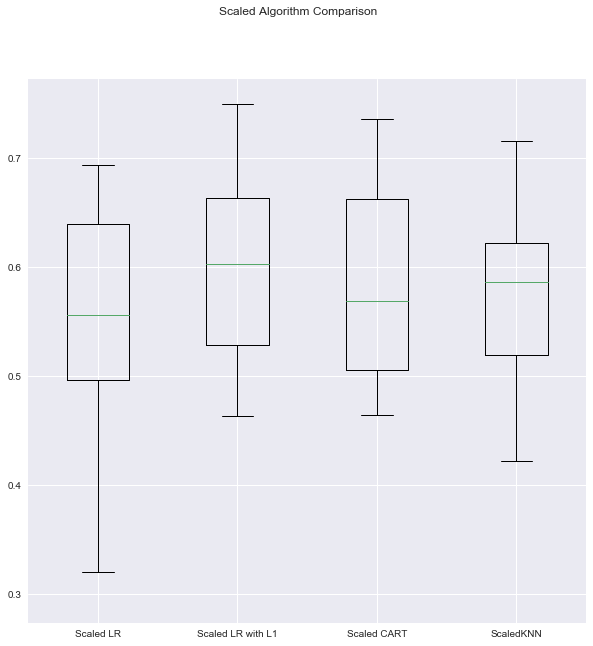

In [24]:
fig = pyplot.figure(figsize=(10,10))
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

Try, some ensemble model, and see their performance

In [25]:
# ensembles
ensembles = []

ensembles.append(('RF', RandomForestClassifier()))
ensembles.append(('ET', ExtraTreesClassifier()))
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

RF: 0.609165 (0.054061)
ET: 0.559915 (0.088540)


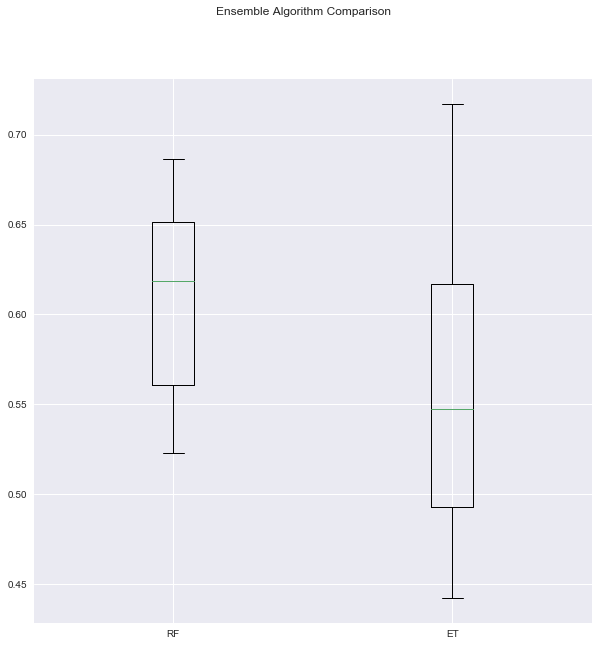

In [26]:
# Compare Algorithms
fig = pyplot.figure(figsize=(10,10))
fig.suptitle('Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
#     plt.xticks.set_color('black')
#     plt.yticks.set_color('black')
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    #ax.xaxis.label.set_color('red')
    #plt.xlabel.set_color('black')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def visualize_tree(tree,feature_names,file_name):
    """Create tree png using graphviz.
    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open(file_name, 'w') as f:
        export_graphviz(tree, out_file=f,feature_names=feature_names)
    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to produce visualization")

Since our goal is interpret-ability of our features, we will stick to models like Logistic regression, Decision Tree. Ensemble methods too can be used, since they provide a feature importance indication .

In the below cells, we try out various algorithms. Use grid search to best tune the hyper parameters and using  cross - validation, to ensure we do not over fit the training data.

In [28]:
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

seed = 13
dtcf = DecisionTreeClassifier(max_depth=1,random_state=seed) 

# n_estimator = list(range(10,500,10))
#print(dtcf.get_params)
param_grid = { 
    
    'max_depth': list(range(1,10,3)),
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split' : list(range(2,20,1)),
     'criterion':['entropy','gini']
}

CV_dtcf = GridSearchCV(estimator=dtcf,param_grid=param_grid, cv= 5,scoring='roc_auc')
CV_dtcf.fit(X_train, y_train)

print (CV_dtcf.best_params_)
print (CV_dtcf.best_score_)


predictions_train = CV_dtcf.best_estimator_.predict_proba(X_train)[:,1]
print("Train ROC-AUC :",roc_auc_score(y_train, predictions_train))
predictions = CV_dtcf.best_estimator_.predict_proba(X_test)[:,1]
print("Test ROC_AUC :",roc_auc_score(y_test, predictions))
visualize_tree(CV_dtcf.best_estimator_, X_train.columns,"dt_cv.txt")


{'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto', 'min_samples_split': 15}
0.6139105139599397
Train ROC-AUC : 0.862805157856
Test ROC_AUC : 0.549528301887


In [29]:
seed=13
model = DecisionTreeClassifier(max_depth=3,criterion='entropy',random_state=seed)
model.fit(X_train, y_train)
#estimate on train data
predictions_train = model.predict_proba(X_train)[:,1]
print("Train ROC-AUC :",roc_auc_score(y_train, predictions_train))
predictions = model.predict_proba(X_test)[:,1]
print("Test ROC_AUC :",roc_auc_score(y_test, predictions))
visualize_tree(model, X_train.columns,"dt_entropy.txt")

Train ROC-AUC : 0.743254405286
Test ROC_AUC : 0.693214804064


In [30]:
#Find Feature Importance with Random Forest Classifer and Extra Tress Classifier

In [31]:
# from sklearn.grid_search import GridSearchCV
# from sklearn.datasets import make_classification
# from sklearn.ensemble import RandomForestClassifier

# rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

# # n_estimator = list(range(10,500,10))
# # print(n_estimator)
# param_grid = { 
#     'n_estimators': list(range(10,500,10)),
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : list(range(3,9,1))
# }

# CV_rfc = GridSearchCV(estimator=rfc,param_grid=param_grid, cv= 5,scoring='roc_auc')
# CV_rfc.fit(X_train, y_train)
# print (CV_rfc.best_params_)

In [32]:
# Build a forest and compute the feature importances
def visualizeFeatureImportance(model,feature_names,no_of_features):
    forest = model
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
    indices = np.argsort(importances)[::-1]
    features = no_of_features
    # Print the feature ranking
    print("Feature ranking:")
    for f in range(features):
        print("%d. feature %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))
    # Plot the feature importances of the forest
    plt.figure(figsize=(10,10))
    plt.title("Feature importances")
    plt.bar(range(features), importances[indices[:features]],color="r", yerr=std[indices[:features]], align="center")
    plt.xticks(range(features), indices[:features])
    plt.xlim([-1,features])
    plt.show()

Train ROC-AUC : 0.702780837004
Test ROC-AUC : 0.589259796807
Feature ranking:
1. feature avr_university (0.068264)
2. feature avr_travel_agency (0.067630)
3. feature rating_dentist (0.065132)
4. feature n_rating_per_entity_store_spa (0.062952)
5. feature n_review (0.056685)
6. feature entity_per_store_jewelry_store (0.053597)
7. feature total_user_rating_restaurant (0.053468)
8. feature n_bakery (0.050825)
9. feature avr_spa (0.049250)
10. feature rating_per_entity_store_post_office (0.044837)


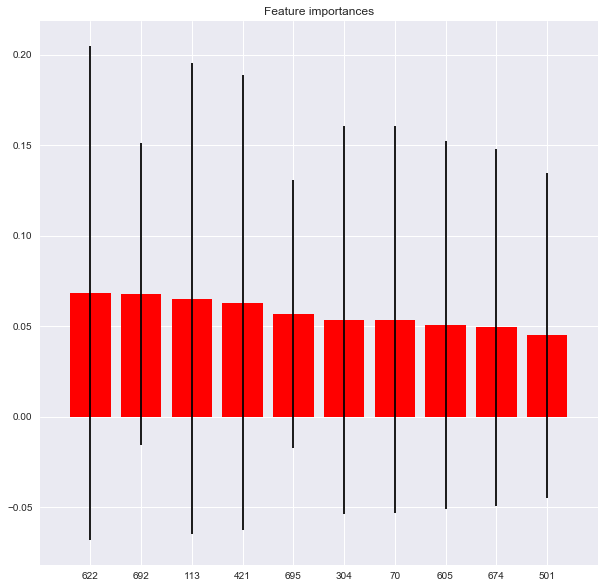

In [33]:
seed = 19
rf_clf = RandomForestClassifier(n_estimators=5,max_depth=3,random_state=seed,max_features='sqrt')
rf_clf.fit(X_train,y_train)
predictions_train = rf_clf.predict(X_train)
print("Train ROC-AUC :",roc_auc_score(y_train, predictions_train))
# estimate accuracy on validation dataset

predictions = rf_clf.predict(X_test)
print("Test ROC-AUC :",roc_auc_score(y_test, predictions))
visualizeFeatureImportance(rf_clf,X_train.columns,10)

Train AUC : 0.743931259178
Test AUC : 0.647677793904
Feature ranking:
1. feature entity_per_store_gym (0.101984)
2. feature rating_per_entity_store_physiotherapist (0.087518)
3. feature city_GR (0.071863)
4. feature rating_dentist (0.060138)
5. feature entity_per_store_jewelry_store (0.054807)
6. feature rating_home_goods_store (0.054117)
7. feature entity_per_store_bar (0.050996)
8. feature avr_gym (0.040799)
9. feature avr_electrician (0.039407)
10. feature n_store (0.038358)


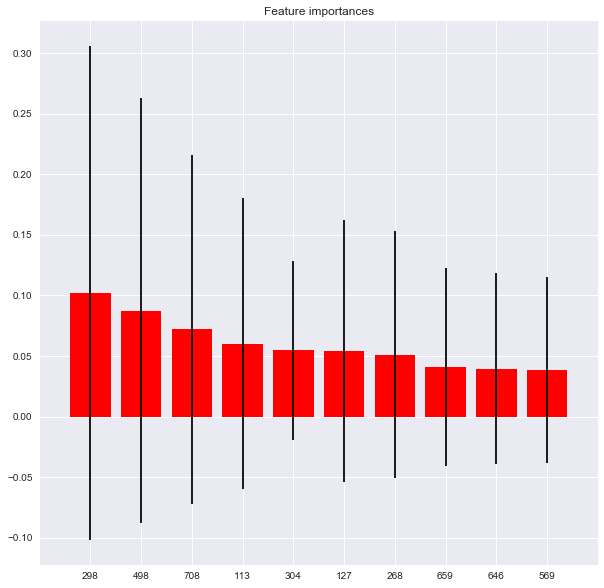

In [34]:
# prepare the model

seed = 17

model_et = ExtraTreesClassifier(n_estimators=5,max_depth=3,bootstrap=True,max_features='sqrt',random_state=seed)
model_et.fit(X_train, y_train)

predictions_train = model_et.predict_proba(X_train)[:,1]
print("Train AUC :",roc_auc_score(y_train,predictions_train))

predictions = model_et.predict_proba(X_test)[:,1]
print("Test AUC :",roc_auc_score(y_test,predictions))

visualizeFeatureImportance(model_et,X_train.columns,10)

In [35]:
from sklearn.grid_search import GridSearchCV,RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer

validation_size = 0.30
seed = 13
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=validation_size,random_state=seed)

scaler = Normalizer().fit(X_train)
normalizedX = scaler.transform(X_train)

lr = LogisticRegression(C=1,n_jobs=10,penalty='l1') 
param_grid = { 'C': np.arange(1,100,1)}

CV_lr = RandomizedSearchCV(estimator=lr,param_distributions=param_grid, cv=10,scoring='roc_auc',random_state=seed)
CV_lr.fit(normalizedX, y_train)
print (CV_lr.best_params_)

{'C': 10}


In [36]:
lr = CV_lr.best_estimator_
lr.fit(normalizedX, y_train)

predictions_train = lr.predict_proba(normalizedX)[:,1]
print("Train AUC :",roc_auc_score(y_train,predictions_train))

normalizedX_test = scaler.transform(X_test)
predictions = lr.predict_proba(normalizedX_test)[:,1]

print("Test ROC_AUC :",roc_auc_score(y_test, predictions))

Train AUC : 0.835678210678
Test ROC_AUC : 0.596598202824


In [37]:
# from tpot import TPOTClassifier

# # prepare the model
# model = TPOTClassifier(generations=5, population_size=50, verbosity=2,cv=10,scoring='roc_auc')
# model.fit(X_train, y_train)

# predictions = model.predict(X_test)

# print(roc_auc_score(y_test, predictions))
# print(confusion_matrix(y_test, predictions))


Sci-kit learn provide facilities from feature selection to improve estimators accuracy scores or to boost their performance on very high-dimensional datasets.

We compute the ANOVA F-value for the data, using the SelectKBest methods and use these as inputs to various algorithms. 

In [38]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
import pandas as pd


selector = SelectKBest(chi2, k=15)
selector.fit(X_train, y_train)

X_new = selector.transform(X)
X_new.shape
X.columns[selector.get_support(indices=True)]
chi2_list = X.columns[selector.get_support(indices=True)].tolist()
print(chi2_list,"\n")

    
selector = SelectKBest(f_classif, k=15)
selector.fit(X, y)
X_new = selector.transform(X)
X_new.shape
X.columns[selector.get_support(indices=True)]
f_classif_list = X.columns[selector.get_support(indices=True)].tolist()
print(f_classif_list,"\n")
    
selector = SelectKBest(mutual_info_classif, k=15)
selector.fit(X, y)
X_new = selector.transform(X)
X_new.shape
X.columns[selector.get_support(indices=True)]
mic_list  = X.columns[selector.get_support(indices=True)].tolist()
print(mic_list,"\n")
    

['total_user_rating_department_store', 'total_user_rating_shopping_mall', 'n_rating_per_entity_store_cafe', 'n_rating_per_entity_store_city_hall', 'n_rating_per_entity_store_department_store', 'n_rating_per_entity_store_electronics_store', 'n_rating_per_entity_store_home_goods_store', 'n_rating_per_entity_store_liquor_store', 'n_rating_per_entity_store_meal_takeaway', 'n_rating_per_entity_store_park', 'n_rating_per_entity_store_restaurant', 'n_rating_per_entity_store_shopping_mall', 'n_rating_per_entity_store_subway_station', 'n_rating_per_entity_store_train_station', 'n_review'] 

['total_user_rating_beauty_salon', 'total_user_rating_doctor', 'total_user_rating_hair_care', 'rating_insurance_agency', 'rating_spa', 'n_rating_per_entity_store_doctor', 'n_rating_per_entity_store_hair_care', 'rating_per_entity_store_dentist', 'rating_per_entity_store_hair_care', 'n_pharmacy', 'n_meal_takeaway', 'n_store', 'n_gym', 'avr_insurance_agency', 'n_review'] 

['total_user_rating_gym', 'nf_enity_st

In [39]:
#First Level of segregation using f_classif_list
X_sub = X[X.columns.intersection(f_classif_list)]
y_sub = y

print("Shape ",X_sub.shape)
print ("Shape ",y.shape )


#Divide 
validation_size = 0.30
seed = 19

X_train, X_test, y_train, y_test = train_test_split(X_sub,y_sub,test_size=validation_size,random_state=seed)

dtcf = DecisionTreeClassifier(max_depth=2,random_state=seed) 


param_grid = { 
    
    'max_depth': list(range(2,10,1)),
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split' : list(range(2,20,1)),
     'criterion':['entropy','gini']
}

CV_dtcf = RandomizedSearchCV(estimator=dtcf,param_distributions=param_grid, cv= 5,scoring='roc_auc',
                             random_state=seed)
CV_dtcf.fit(X_train, y_train)

print (CV_dtcf.best_params_)
#print (CV_dtcf.best_score_)


predictions_train = CV_dtcf.best_estimator_.fit(X_train, y_train).predict_proba(X_train)[:,1]
print("Train ROC-AUC :",roc_auc_score(y_train, predictions_train))

predictions = CV_dtcf.best_estimator_.predict_proba(X_test)[:,1]
print("Test ROC-AUC :",roc_auc_score(y_test, predictions))

visualize_tree(CV_dtcf.best_estimator_,X_train.columns,"dt_f_classif_sub.txt")

Shape  (524, 15)
Shape  (524,)
{'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 2, 'criterion': 'gini'}
Train ROC-AUC : 0.684856630824
Test ROC-AUC : 0.612948803191


In [40]:
#Overall data set 
validation_size = 0.30
seed = 17

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=validation_size,random_state=seed)

dtcf = DecisionTreeClassifier(max_depth=2,random_state=seed) 


param_grid = { 
    
    'max_depth': list(range(2,10,1)),
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split' : list(range(3,10,1)),
     'criterion':['entropy','gini']
}

CV_dtcf = RandomizedSearchCV(estimator=dtcf,param_distributions=param_grid, cv= 5,scoring='roc_auc',random_state=seed)
CV_dtcf.fit(X_train, y_train)

print (CV_dtcf.best_params_)
#print (CV_dtcf.best_score_)

predictions_train = CV_dtcf.best_estimator_.fit(X_train, y_train).predict_proba(X_train)[:,1]
print("Train ROC-AUC :",roc_auc_score(y_train, predictions_train))

# estimate accuracy on validation dataset
predictions = CV_dtcf.best_estimator_.predict_proba(X_test)[:,1]
print("Test ROC-AUC :" , roc_auc_score(y_test, predictions))

visualize_tree(CV_dtcf.best_estimator_,X_train.columns,"dt_all_data.txt")

{'min_samples_split': 8, 'max_features': 'sqrt', 'max_depth': 2, 'criterion': 'gini'}
Train ROC-AUC : 0.689337349398
Test ROC-AUC : 0.621794871795


In [41]:
# {criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'min_samples_split': 15}
# {'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 4}
# {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'min_samples_split': 11}

Shape  (524, 15)
Shape  (524,)
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 340}
Train ROC-AUC : 0.717025089606
Test ROC-AUC : 0.635638297872
Feature ranking:
1. feature n_rating_per_entity_store_hair_care (0.134679)
2. feature rating_per_entity_store_hair_care (0.112787)
3. feature total_user_rating_hair_care (0.107634)
4. feature total_user_rating_beauty_salon (0.097016)
5. feature n_review (0.087926)
6. feature n_gym (0.081033)
7. feature total_user_rating_doctor (0.075441)
8. feature rating_per_entity_store_dentist (0.065631)
9. feature n_store (0.055898)
10. feature n_rating_per_entity_store_doctor (0.051693)


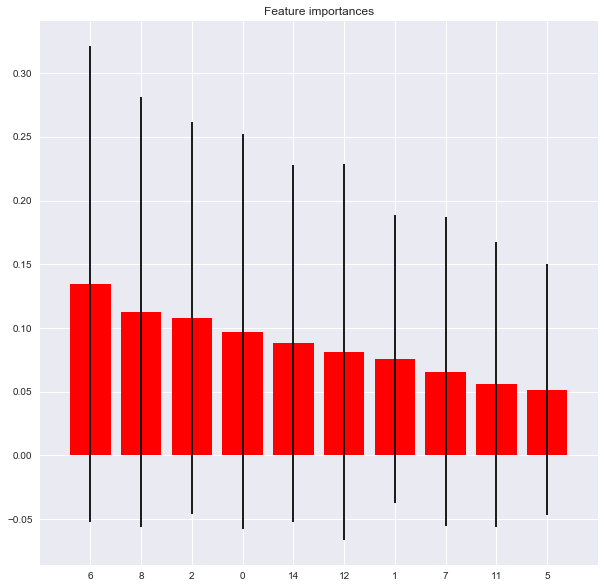

{'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 300}
Train ROC-AUC : 0.664157706093
Test ROC-AUC : 0.625664893617
Feature ranking:
1. feature n_store (0.121911)
2. feature rating_spa (0.092009)
3. feature n_rating_per_entity_store_hair_care (0.085802)
4. feature rating_per_entity_store_hair_care (0.083289)
5. feature n_gym (0.070521)
6. feature rating_per_entity_store_dentist (0.068568)
7. feature n_meal_takeaway (0.058343)
8. feature total_user_rating_beauty_salon (0.057051)
9. feature total_user_rating_hair_care (0.053321)
10. feature n_pharmacy (0.051112)


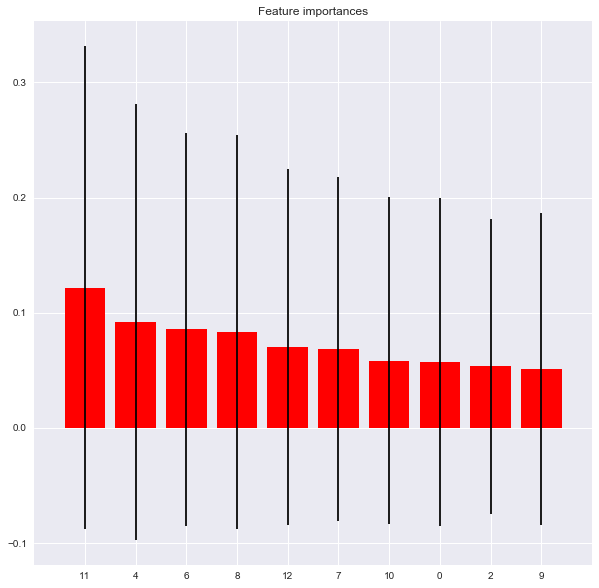

In [42]:
#ensemble_input_col = list(set().union(chi2_list,f_classif_list,mic_list))
ensemble_input_col = list(set().union(f_classif_list))

X_sub = X[X.columns.intersection(ensemble_input_col)]
y_sub = y


print("Shape ",X_sub.shape)
print ("Shape ",y.shape )


#Divide 
validation_size = 0.30
seed = 29
X_train, X_test, y_train, y_test = train_test_split(X_sub,y_sub,test_size=validation_size,random_state=seed)


from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint

rfc = RandomForestClassifier(n_jobs=-1) 

# n_estimator = list(range(10,500,10))
# print(n_estimator)
param_grid = { 
    'n_estimators': list(range(10,500,10)),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : list(range(3,9,1)),
    "min_samples_split": sp_randint(2, 11),
    "min_samples_leaf": sp_randint(2, 11),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]
}

CV_rfc = RandomizedSearchCV(estimator=rfc,param_distributions=param_grid,cv= 5,scoring='roc_auc')
CV_rfc.fit(X_train, y_train)
print (CV_rfc.best_params_)

seed = 29
rf_clf = CV_rfc.best_estimator_

rf_clf.fit(X_train,y_train)
predictions_train = rf_clf.predict(X_train)
print("Train ROC-AUC :",roc_auc_score(y_train, predictions_train))
# estimate accuracy on validation dataset
predictions = rf_clf.predict(X_test)
print("Test ROC-AUC :",roc_auc_score(y_test, predictions))
visualizeFeatureImportance(rf_clf,X_train.columns,10)

et_clf = ExtraTreesClassifier(n_jobs=-1) 

# n_estimator = list(range(10,500,10))
# print(n_estimator)
param_grid = { 
    'n_estimators': list(range(10,500,10)),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : list(range(3,9,1)),
    "min_samples_split": sp_randint(2, 11),
    "min_samples_leaf": sp_randint(2, 11),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]
}

CV_et_clf = RandomizedSearchCV(estimator=et_clf,param_distributions=param_grid,cv= 5,scoring='roc_auc')
CV_et_clf.fit(X_train, y_train)
print (CV_et_clf.best_params_)


seed = 29
et_clf = CV_et_clf.best_estimator_
et_clf.fit(X_train,y_train)
predictions_train = et_clf.predict(X_train)
print("Train ROC-AUC :",roc_auc_score(y_train, predictions_train))
# estimate accuracy on validation dataset
predictions = et_clf.predict(X_test)
print("Test ROC-AUC :",roc_auc_score(y_test, predictions))
visualizeFeatureImportance(et_clf,X_train.columns,10)


{'alpha': 0.11}
Train AUC : 0.831991557365
Test ROC_AUC : 0.594456016664
0.11
Features survied : 53
{'bootstrap': False, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 6, 'n_estimators': 440}
Train ROC-AUC : 0.815770609319
Test ROC-AUC : 0.602227393617
Feature ranking:
1. feature rating_per_entity_store_hair_care (0.087757)
2. feature n_rating_per_entity_store_dentist (0.071842)
3. feature n_doctor (0.064616)
4. feature total_user_rating_bar (0.058096)
5. feature no_of_near_by_shops (0.052166)
6. feature n_rating_per_entity_store_transit_station (0.046086)
7. feature n_rating_per_entity_store_gym (0.038931)
8. feature n_review (0.037952)
9. feature n_clothing_store (0.033279)
10. feature n_rating_per_entity_store_store (0.031652)


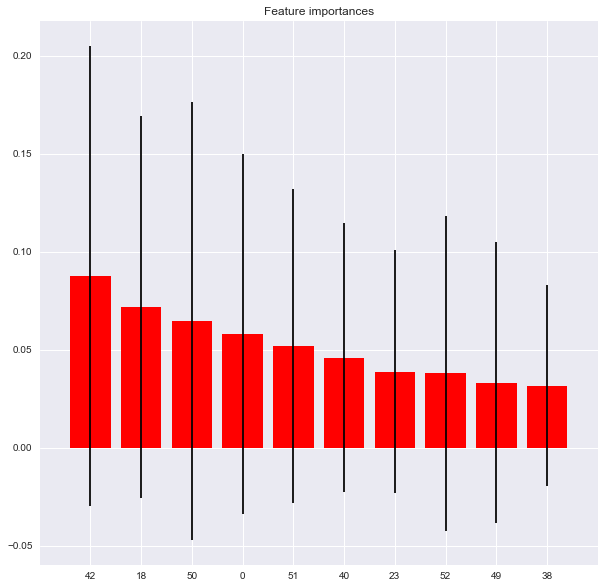

{'bootstrap': True, 'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 340}
Train ROC-AUC : 0.717025089606
Test ROC-AUC : 0.635970744681
Feature ranking:
1. feature n_store (0.060951)
2. feature rating_per_entity_store_hair_care (0.059762)
3. feature n_doctor (0.049991)
4. feature rating_per_entity_store_pharmacy (0.048338)
5. feature rating_per_entity_store_spa (0.045181)
6. feature n_rating_per_entity_store_dentist (0.042097)
7. feature no_of_near_by_shops (0.037869)
8. feature n_clothing_store (0.031111)
9. feature n_review (0.029542)
10. feature total_user_rating_lodging (0.026820)


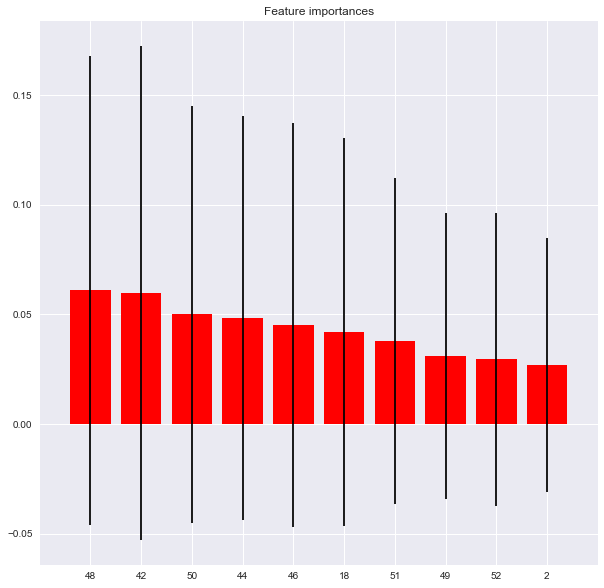

In [43]:
#Lasso Regression for variable selection and Random forest for feature imporatnce .

validation_size = 0.30
seed = 23

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=validation_size,random_state=seed)

from sklearn import linear_model
ls_clf = linear_model.Lasso(alpha=0.01,selection='random')
param_grid = { 'alpha': np.arange(0.1,1,0.01)}


CV_lr = GridSearchCV(estimator=ls_clf,param_grid=param_grid, cv=10,scoring='roc_auc')
CV_lr.fit(X_train, y_train)
print (CV_lr.best_params_)


CV_lr.best_estimator_.fit(X_train,y_train)
predictions_train = CV_lr.best_estimator_.predict(X_train)
print("Train AUC :",roc_auc_score(y_train,predictions_train))
predictions = CV_lr.best_estimator_.predict(X_test)
print("Test ROC_AUC :",roc_auc_score(y_test, predictions))
# print (len(CV_lr.best_estimator_.coef_))
# print (len(X.columns))
print (CV_lr.best_estimator_.alpha)

lasso_survival_list = []
for i in range(0,len(X.columns)):
    if CV_lr.best_estimator_.coef_[i]!=0:
        lasso_survival_list.append(X.columns[i])
print ("Features survied :",len(lasso_survival_list))

#Subselect the data using the variables survived from Lasso
X_sub = X[X.columns.intersection(lasso_survival_list)]
y_sub = y

#Divide 
validation_size = 0.30
seed = 29
X_train, X_test, y_train, y_test = train_test_split(X_sub,y_sub,test_size=validation_size,random_state=seed)


from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint

rfc = RandomForestClassifier(n_jobs=-1) 

# n_estimator = list(range(10,500,10))
# print(n_estimator)
param_grid = { 
    'n_estimators': list(range(10,500,10)),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : list(range(3,9,1)),
    "min_samples_split": sp_randint(2, 11),
    "min_samples_leaf": sp_randint(2, 11),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]
}

CV_rfc = RandomizedSearchCV(estimator=rfc,param_distributions=param_grid,cv= 5,scoring='roc_auc')
CV_rfc.fit(X_train, y_train)
print (CV_rfc.best_params_)

seed = 29
rf_clf = CV_rfc.best_estimator_

rf_clf.fit(X_train,y_train)
predictions_train = rf_clf.predict(X_train)
print("Train ROC-AUC :",roc_auc_score(y_train, predictions_train))
# estimate accuracy on validation dataset
predictions = rf_clf.predict(X_test)
print("Test ROC-AUC :",roc_auc_score(y_test, predictions))
visualizeFeatureImportance(rf_clf,X_train.columns,10)

et_clf = ExtraTreesClassifier(n_jobs=-1) 

# n_estimator = list(range(10,500,10))
# print(n_estimator)
param_grid = { 
    'n_estimators': list(range(10,500,10)),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : list(range(3,9,1)),
    "min_samples_split": sp_randint(2, 11),
    "min_samples_leaf": sp_randint(2, 11),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]
}

CV_et_clf = RandomizedSearchCV(estimator=et_clf,param_distributions=param_grid,cv= 5,scoring='roc_auc')
CV_et_clf.fit(X_train, y_train)
print (CV_et_clf.best_params_)


seed = 29
et_clf = CV_et_clf.best_estimator_
et_clf.fit(X_train,y_train)
predictions_train = et_clf.predict(X_train)
print("Train ROC-AUC :",roc_auc_score(y_train, predictions_train))
# estimate accuracy on validation dataset
predictions = et_clf.predict(X_test)
print("Test ROC-AUC :",roc_auc_score(y_test, predictions))
visualizeFeatureImportance(et_clf,X_train.columns,10)


{'C': 98}
Train AUC : 0.984139784946
Test AUC : 0.506981382979
731
98
1
Features survived for RF : 150
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 90}
Train ROC-AUC : 0.826344086022
Test ROC-AUC : 0.628490691489
Feature ranking:
1. feature n_rating_per_entity_store_beauty_salon (0.059801)
2. feature total_user_rating_hair_care (0.039942)
3. feature nf_enity_store_id_hair_care (0.039157)
4. feature n_rating_per_entity_store_dentist (0.030645)
5. feature n_real_estate_agency (0.028476)
6. feature n_rating_per_entity_store_gym (0.027127)
7. feature total_user_rating_bar (0.018932)
8. feature rating_per_entity_store_beauty_salon (0.018916)
9. feature rating_pharmacy (0.017914)
10. feature n_gym (0.017903)


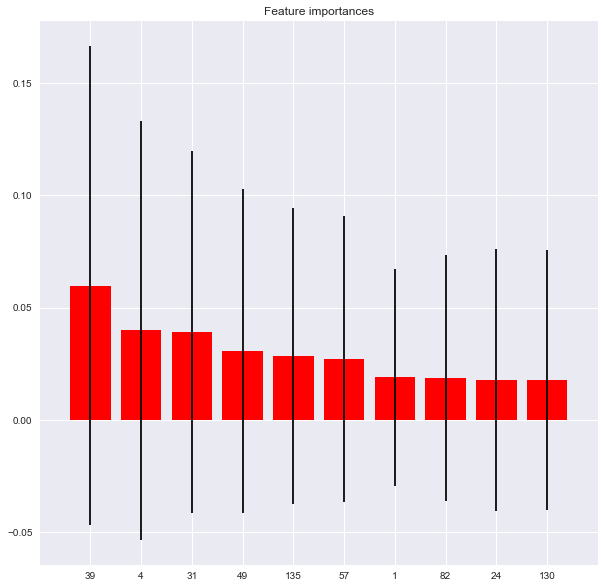

{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 310}
Train ROC-AUC : 0.760573476703
Test ROC-AUC : 0.601894946809
Feature ranking:
1. feature city_VD (0.046003)
2. feature n_rating_per_entity_store_dentist (0.033989)
3. feature n_gym (0.032241)
4. feature avr_pharmacy (0.027409)
5. feature rating_per_entity_store_beauty_salon (0.024877)
6. feature avr_gym (0.023118)
7. feature avr_beauty_salon (0.022947)
8. feature n_rating_per_entity_store_pharmacy (0.021137)
9. feature rating_per_entity_store_hair_care (0.020487)
10. feature n_store (0.019985)


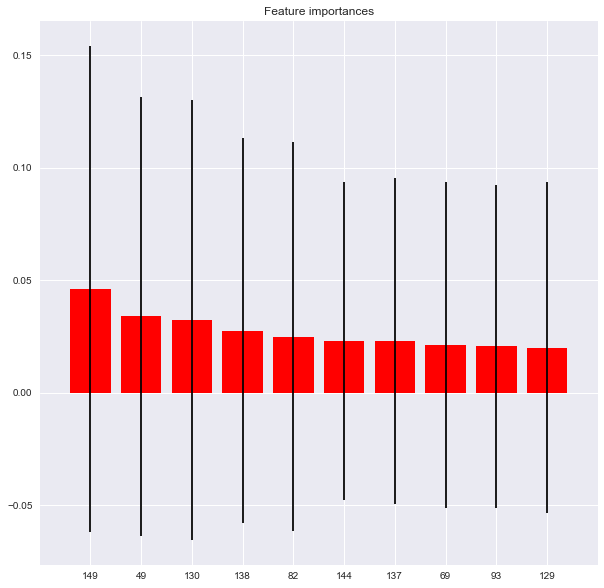

In [44]:
#Logistic Regression with L1 Penalty for variable selection and Random forest for feature imporatnce .

validation_size = 0.30
seed = 29
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=validation_size,random_state=seed)

from sklearn import linear_model

scaler = Normalizer().fit(X_train)
normalizedX = scaler.transform(X_train)
lr = LogisticRegression(C=1,n_jobs=10,penalty='l1') 
param_grid = { 'C': np.arange(1,100,1)}
CV_lr = RandomizedSearchCV(estimator=lr,param_distributions=param_grid, cv=10,scoring='roc_auc')
CV_lr.fit(normalizedX, y_train)
print (CV_lr.best_params_)
lr = CV_lr.best_estimator_
lr.fit(normalizedX, y_train)

predictions_train = lr.predict_proba(normalizedX)[:,1]
print("Train AUC :",roc_auc_score(y_train,predictions_train))

normalizedX_test = scaler.transform(X_test)
predictions = lr.predict_proba(normalizedX_test)[:,1]
print("Test AUC :",roc_auc_score(y_test,predictions))

print (len(X.columns))
print (lr.C)
print (len(lr.coef_))

survival_list = []

for i in range(0,len(X.columns)):
    if lr.coef_[:,i]!=0:
        survival_list.append(X.columns[i])
print ("Features survived for RF :",len(survival_list))

#Subselect the data using the variables survived from Lasso
X_sub = X[X.columns.intersection(survival_list)]
y_sub = y

#Divide 
validation_size = 0.30
seed = 29
X_train, X_test, y_train, y_test = train_test_split(X_sub,y_sub,test_size=validation_size,random_state=seed)


from sklearn.grid_search import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_jobs=-1) 

# n_estimator = list(range(10,500,10))
# print(n_estimator)
param_grid = { 
    'n_estimators': list(range(10,100,10)),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : list(range(3,5,1)),
    "min_samples_split": sp_randint(2, 11),
    "min_samples_leaf": sp_randint(2, 11),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]
}

CV_rfc = RandomizedSearchCV(estimator=rfc,param_distributions=param_grid,cv= 5,scoring='roc_auc',random_state=seed)
CV_rfc.fit(X_train, y_train)
print (CV_rfc.best_params_)

rf_clf = CV_rfc.best_estimator_
rf_clf.fit(X_train,y_train)
predictions_train = rf_clf.predict(X_train)
print("Train ROC-AUC :",roc_auc_score(y_train, predictions_train))
# estimate accuracy on validation dataset
predictions = rf_clf.predict(X_test)
print("Test ROC-AUC :",roc_auc_score(y_test, predictions))
visualizeFeatureImportance(rf_clf,X_train.columns,10)


#Randomised search for ET Classifier

et_clf = ExtraTreesClassifier(n_jobs=-1) 

# n_estimator = list(range(10,500,10))
# print(n_estimator)
param_grid = { 
    'n_estimators': list(range(10,500,10)),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : list(range(3,5,1)),
    "min_samples_split": sp_randint(2, 11),
    "min_samples_leaf": sp_randint(2, 11),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]
}

CV_et_clf = RandomizedSearchCV(estimator=et_clf,param_distributions=param_grid,cv= 5,scoring='roc_auc',
                               random_state=seed)
CV_et_clf.fit(X_train, y_train)
print (CV_et_clf.best_params_)


seed = 29
et_clf = CV_et_clf.best_estimator_
et_clf.fit(X_train,y_train)
predictions_train = et_clf.predict(X_train)
print("Train ROC-AUC :",roc_auc_score(y_train, predictions_train))
# estimate accuracy on validation dataset
predictions = et_clf.predict(X_test)
print("Test ROC-AUC :",roc_auc_score(y_test, predictions))
visualizeFeatureImportance(et_clf,X_train.columns,10)

In [45]:
# effect_list = []
# for i in range(0,len(X.columns)):
#     if lr.coef_[:,i]!=0:
#         effect_list.append(X.columns[i]+str(lr.coef_[:,i]))
# print ("LR feature co-efficient :",effect_list)

In [46]:
print("Train Accuracy :",accuracy_score(y_train, predictions_train))
# estimate accuracy on validation dataset
predictions = et_clf.predict(X_test)
print("Test Accuracy :",accuracy_score(y_test, predictions))

Train Accuracy : 0.75956284153
Test Accuracy : 0.588607594937


In [47]:
# target_names = ['class 0', 'class 1']
# print(classification_report(y_test, predictions, target_names=target_names))

In [48]:
# tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [49]:
# tn, fp, fn, tp

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure(figsize=(10,10))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


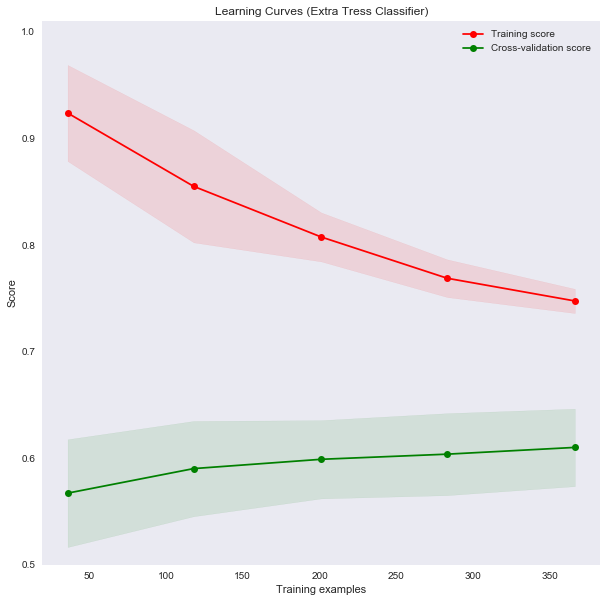

In [51]:
title = "Learning Curves (Extra Tress Classifier)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50,test_size=0.3, random_state=0)
estimator = et_clf
plot_learning_curve(estimator, title, X, y, ylim=(0.5, 1.01), cv=cv, n_jobs=4)
plt.show()

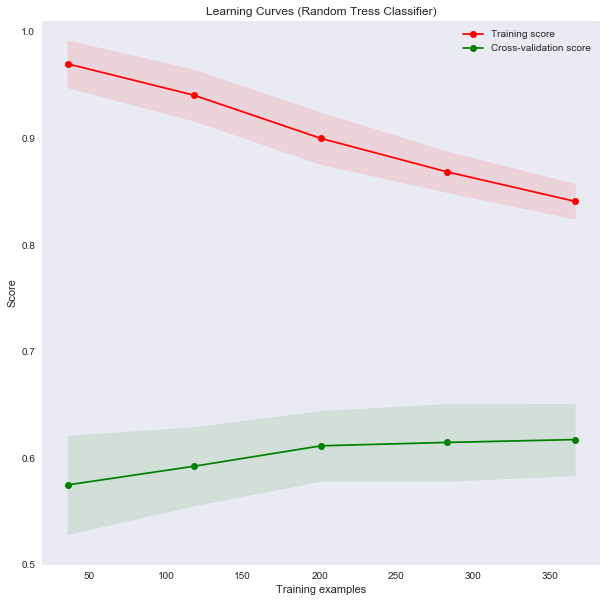

In [52]:
title = "Learning Curves (Random Tress Classifier)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50,test_size=0.3, random_state=0)
estimator = rf_clf
plot_learning_curve(estimator, title, X, y, ylim=(0.5, 1.01), cv=cv)
plt.show()

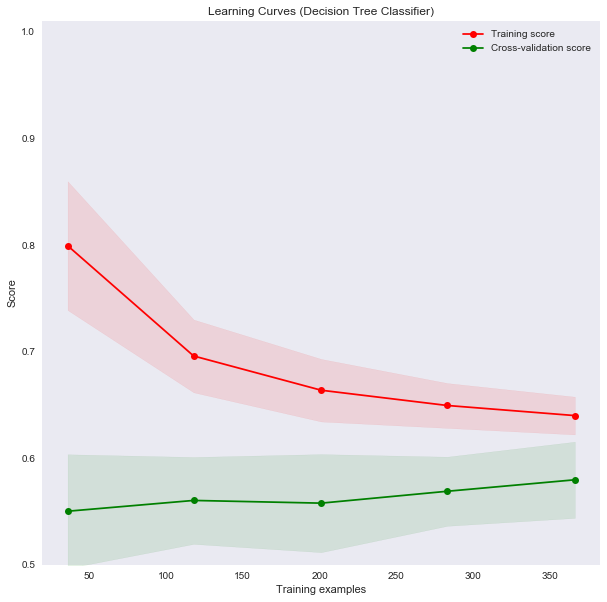

In [53]:
title = "Learning Curves (Decision Tree Classifier)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50,test_size=0.3, random_state=0)
estimator = CV_dtcf.best_estimator_
plot_learning_curve(estimator, title, X, y, ylim=(0.5, 1.01), cv=cv)
plt.show()

In [54]:
# title = "Learning Curves (Logistic Regression Classifier)"
# # Cross validation with 100 iterations to get smoother mean test and train
# # score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=10,test_size=0.3, random_state=0)
# estimator = CV_lr.best_estimator_
# plot_learning_curve(estimator, title, X, y, ylim=(0.5, 1.01),cv=cv)
# plt.show()